In [65]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pprint as pp
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import heapq
import json
data = {}
json_list = os.listdir('bbg_json/')

In [66]:
for fname in tqdm(json_list):
    with open(os.path.join('bbg_json',fname), 'r') as f:
        data[fname.split('.')[0]] = json.load(f)

100%|██████████| 5478/5478 [00:03<00:00, 1438.65it/s]


In [67]:
def for_kids(game):
    return int(game['age']) < 8 and int(game['age']) > 0
kids_games = list(filter(for_kids, data.values()))


In [68]:
len(kids_games)

868

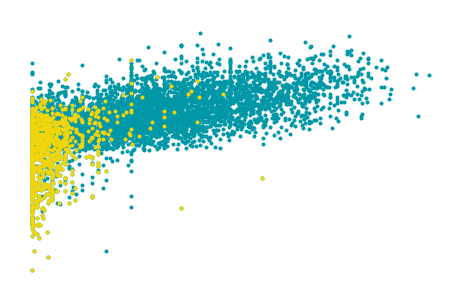

In [69]:
# Let's plot the average weight vs average score

plt.figure(figsize=(8,5))
plt.plot([g['stats']['averageweight'] for g in data.values()], [g['stats']['average'] for g in data.values()],'.', color = '#0097a7')
plt.plot([g['stats']['averageweight'] for g in kids_games], [g['stats']['average'] for g in kids_games],'.', color = '#F2D60C')

#clue = next(filter(lambda x: x['name'].lower() == 'clue', data.values()))
#catan = next(filter(lambda x: x['name'].lower() == 'catan', data.values()))
#gloomhaven =  next(filter(lambda x: x['name'].lower() == 'gloomhaven', data.values()))
#guess_who = data['4143']
#for game in [guess_who, clue, catan, gloomhaven]:
#    plt.plot(game['stats']['averageweight'],game['stats']['average'], '*',markersize=40, color='#B31269')
plt.ylim(2,10)
plt.xlim(.75,None)
plt.axis('off')
#plt.savefig('kids_game_ratings.png', transparent=True, dpi=200)
#plt.savefig('game_ratings_with_games.png', transparent=True, dpi=200)
#plt.savefig('game_ratings.png', transparent=True, dpi=200)
plt.show()

In [70]:
pp.pprint(data['4143'])

{'age': '6',
 'comments': [{'comment': 'KIDS ',
               'rating': '6',
               'username': '1 Family Meeple'},
              {'comment': 'Great fun for kids',
               'rating': '4',
               'username': '1000rpm'},
              {'comment': 'I remember having fun with this as a kid; would '
                          'like to try it again.',
               'rating': '6',
               'username': '2018'},
              {'comment': 'Boring',
               'rating': '3',
               'username': '2ndinBeautyContest'},
              {'comment': 'Dr. Who remake\n2 p',
               'rating': '5',
               'username': '3sapphires'},
              {'comment': 'D3', 'rating': 'N/A', 'username': 'ABCafe'},
              {'comment': 'Home.', 'rating': 'N/A', 'username': 'AbigailEMG'},
              {'comment': 'Original',
               'rating': 'N/A',
               'username': 'Abslom_Daak'},
              {'comment': 'The base game is very mechanical wit

In [71]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']


In [29]:
n_comments = len(deduc_comments)
sum = 0
for elm in  map(sentiment_analyzer_scores, deduc_comments):
    sum += elm
print(sum/n_comments)

0.5633750000000001


In [93]:
def new_score(game, search_string, norm = 15.0,):
    rel_comments = filter(lambda x: search_string in x['comment'], game['comments'])
    rel_comments = list(map(lambda x: x['comment'], rel_comments))
    n_comments = len(rel_comments) 
    sum = 0
    if n_comments > 5:
        for elm in  map(sentiment_analyzer_scores, rel_comments):
            sum += elm
        return (game['stats']['average'] + sum/n_comments * norm)/2
    else:
        return -1

In [77]:
new_score(data['4143'],'deduc')

6.6179825

In [94]:
def return_n_best(N, search_string):
    return heapq.nlargest(N, map(lambda g: (new_score(g, search_string), g['name']), kids_games))


In [95]:
return_n_best(5, 'deduc')

[(8.78824, 'Barnyard Buddies'),
 (8.732835000000001, 'Kto to był?'),
 (8.458252727272725, 'Lisek urwisek'),
 (7.905735, 'Mastermind for Kids'),
 (7.877885714285714, 'Abraca... Boh!')]

In [96]:
return_n_best(5, 'learn')

[(10.47261, 'Carcassonne'),
 (10.4203625, 'Croa'),
 (10.374175000000001, 'Mijnlieff'),
 (10.35173, 'Lisek urwisek'),
 (10.293599999999998, 'Go Away Monster!')]

In [98]:
return_n_best(5, 'pattern')

[(9.75593, 'Chodí Pešek okolo'),
 (8.3795125, 'Six'),
 (7.785565000000002, 'Fazantenbal'),
 (7.734480000000001, 'Blink'),
 (7.632991923076924, 'Carrousel')]

In [99]:
return_n_best(5, 'memo')

[(9.6682025, 'Cappuccetto Rosso e il Lupo Cattivo'),
 (9.652515000000001, 'Geisterwäldchen'),
 (9.2816625, 'Battling Ships'),
 (8.998145909090908, 'Boo Who'),
 (8.927663333333333, 'Au Bal Masqué des Coccinelles')]